In [6]:
import networkx as nx
import copy

In [18]:
def louvain_algorithm(G):

    # takes in a networkX graph
    # statistics for testing 
    stats = {
        'modularity_calculations': 0,
        'node_moves': 0,
        'phases': 0,
        'iterations': 0
    }
    
    # Start with each node in its own community
    node_to_community = {node: node for node in G.nodes()}
    
    # Calculate total weight of graph (for modularity)
    m = G.size(weight='weight')
    if m == 0:  # Handle graph with no edge weights 
        m = size(G.nodes) # is graph has no edge weights then all edges have weight 1

    #actual algorithm begins
    improved = True
    
    # Keep going until no improvement
    while improved:
        stats['phases'] += 1
        improved = False
        
        # Phase 1: Move nodes to optimize modularity
        changed = True
        while changed:
            stats['iterations'] += 1
            changed = False
            
            # Try moving each node to a better community
            for node in G.nodes():
                current_comm = node_to_community[node]
                
                # Calculate current node's degree
                node_degree = G.degree(node, weight='weight')
                
                # Find neighboring communities
                neighbor_comms = set()
                for neighbor in G.neighbors(node):
                    neighbor_comms.add(node_to_community[neighbor])
                
                # Also consider the current community
                neighbor_comms.add(current_comm)
                
                # Find best community for this node
                best_comm = current_comm
                best_gain = 0
                
                for comm in neighbor_comms:
                    # Calculate modularity gain if we move to this community
                    gain = calculate_modularity_gain( G, node, comm, node_to_community, m)
                    stats['modularity_calculations'] += 1
                    
                    if gain > best_gain:
                        best_gain = gain
                        best_comm = comm
                
                # Move node if we found a better community
                if best_comm != current_comm and best_gain > 0:
                    node_to_community[node] = best_comm
                    changed = True
                    improved = True
                    stats['node_moves'] += 1
        
    """
        # Phase 2: Build a new graph where each community becomes a node (aggregation) 
        if improved:
            G = build_community_graph(G, node_to_community)
            # Update node_to_community for the new graph
            node_to_community = {node: node for node in G.nodes()}
    """
    
    # Convert final node_to_community to the requested format
    communities = {}
    for node, comm in node_to_community.items():
        if comm not in communities:
            communities[comm] = []
        communities[comm].append(node)

    return communities, stats


def calculate_modularity_gain(G, node, target_comm, node_to_community, m):
    """
    Calculate the modularity gain from moving a node to a target community.
    
    Args:
        G: NetworkX graph
        node: The node to potentially move
        target_comm: The community we're considering moving to
        node_to_community: Current mapping of nodes to communities
        m: Total weight of all edges in graph
        
    Returns:
        The modularity gain (can be negative)
    """
    # Calculate edges from node to target community
    ki_in = 0  # edges from node to nodes in target_comm
    for neighbor in G.neighbors(node):
        if node_to_community[neighbor] == target_comm:
            weight = G[node][neighbor].get('weight', 1)
            ki_in += weight
    
    # Calculate total degree of nodes in target community (excluding node if it's in there)
    sigma_tot = 0
    for n in G.nodes():
        if node_to_community[n] == target_comm and n != node:
            sigma_tot += G.degree(n, weight='weight')
    
    # Node's degree
    ki = G.degree(node, weight='weight')
    
    # Modularity gain formula
    # Δ Q = [ki_in - (sigma_tot * ki) / (2m)] / (2m)
    gain = (ki_in - (sigma_tot * ki) / (2 * m)) / (2 * m)
    
    return gain


def build_community_graph(G, node_to_community):
    """
    Build a new graph where each community becomes a single node.
    Edges between communities are weighted by the sum of edges between their members.
    
    Args:
        G: Original graph
        node_to_community: Mapping of nodes to communities
        
    Returns:
        A new NetworkX graph where nodes represent communities
    """
    
    # Create new graph
    new_G = nx.Graph()
    
    # Get unique communities
    communities = set(node_to_community.values())
    new_G.add_nodes_from(communities)
    
    # Add edges between communities
    for u, v in G.edges():
        comm_u = node_to_community[u]
        comm_v = node_to_community[v]
        weight = G[u][v].get('weight', 1)
        
        if comm_u == comm_v:
            # Self-loop in the new graph
            if new_G.has_edge(comm_u, comm_u):
                new_G[comm_u][comm_u]['weight'] += weight
            else:
                new_G.add_edge(comm_u, comm_u, weight=weight)
        else:
            # Edge between different communities
            if new_G.has_edge(comm_u, comm_v):
                new_G[comm_u][comm_v]['weight'] += weight
            else:
                new_G.add_edge(comm_u, comm_v, weight=weight)
    
    return new_G

Communities found:
Community 11: [0, 11, 17, 19, 21]
Community 13: [1, 2, 3, 7, 12, 13]
Community 10: [4, 10]
Community 6: [5, 6, 16]
Community 33: [8, 9, 14, 15, 18, 20, 22, 30, 32, 33]
Community 25: [23, 27]
Community 31: [24, 25, 28, 31]
Community 29: [26, 29]

Statistics:
  Total phases: 2
  Total iterations: 4
  Node moves: 31
  Modularity calculations: 432


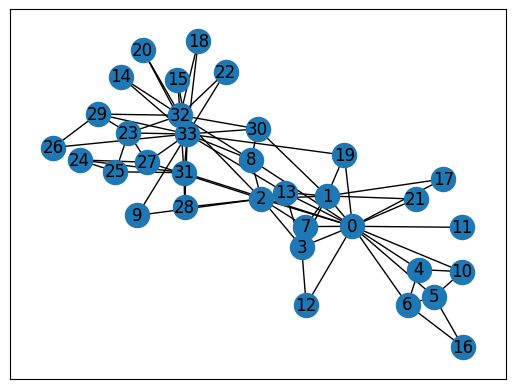

In [19]:
# Create a simple test graph
G = nx.karate_club_graph()
nx.draw_networkx(G)

# Run Louvain algorithm
communities, stats = louvain_algorithm(G)

# Print results
print("Communities found:")
for comm_id, nodes in communities.items():
    print(f"Community {comm_id}: {nodes}")

print(f"\nStatistics:")
print(f"  Total phases: {stats['phases']}")
print(f"  Total iterations: {stats['iterations']}")
print(f"  Node moves: {stats['node_moves']}")
print(f"  Modularity calculations: {stats['modularity_calculations']}")